## Imports

In [1]:
import torch
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torchvision.transforms as transforms

import networks
from utils.transforms import transform_logits, get_affine_transform


import pickle
from collections import namedtuple
from math import sqrt 
import random

import webcolors
from colormath.color_objects import LabColor, sRGBColor  
from colormath.color_conversions import convert_color
from colormath.color_diff_matrix import delta_e_cie2000
from colormath.color_objects import LabColor
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian

### Define variables

In [2]:

image_path = 'test_images/sample.jpg'
input_size = [473, 473]
num_classes = 20
dataset = 'lip'
model_restore = 'checkpoints/exp-schp-201908261155-lip.pth'
gpu = '0'
label = ['Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'Upper-clothes', 'Dress', 'Coat',
                  'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-arm', 'Right-arm',
                  'Left-leg', 'Right-leg', 'Left-shoe', 'Right-shoe']

## Model Inference

In [3]:
# Load model from checkpoint

#   if getting error for importing networks, then check if error msg is because cl.exe is not found. Issue comes about on 
#   windows due to lack of compiler for a module having a c++ implementation. Install a compiler and add it to path. If on VSCode,
#   then open the VS installer and install the C++ compiler with installation settings. Then add the path to the compiler to the PATH environment variable.
model = networks.init_model(name='resnet101', num_classes=num_classes, pretrained=None) 
state_dict = torch.load(model_restore)['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove `module.`
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)
model.cuda()
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): InPlaceABNSync(64, eps=1e-05, momentum=0.1, affine=True, activation=none)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): InPlaceABNSync(64, eps=1e-05, momentum=0.1, affine=True, activation=none)
  (relu2): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): InPlaceABNSync(128, eps=1e-05, momentum=0.1, affine=True, activation=none)
  (relu3): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): InPlaceABNSync(64, eps=1e-05, momentum=0.1, affine=True, activation=none)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): InPlaceABNSync(64

In [4]:
# apply transform to image
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.406, 0.456, 0.485], std=[0.225, 0.224, 0.229])
    ])




In [5]:
# Image processing functions

def _box2cs(box, input_size):
    input_size = np.asarray(input_size)
    x, y, w, h = box[:4]
    return _xywh2cs(x, y, w, h, input_size)

def _xywh2cs(x, y, w, h, input_size ):
    input_size = np.asarray(input_size)
    aspect_ratio = input_size[1] * 1.0 / input_size[0]
    center = np.zeros((2), dtype=np.float32)
    center[0] = x + w * 0.5
    center[1] = y + h * 0.5
    if w > aspect_ratio * h:
        h = w * 1.0 / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio
    scale = np.array([w, h], dtype=np.float32)
    return center, scale

In [6]:
# load image
img_name = image_path.split('/')[-1]
img = cv2.imread(image_path, cv2.IMREAD_COLOR)
real_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape
size = np.asarray(input_size)
person_center, s = _box2cs([0, 0, w - 1, h - 1], input_size=size)
r = 0
trans = get_affine_transform(person_center, s, r, size)
input = cv2.warpAffine(
        img,
        trans,
        (int(size[1]), int(size[0])),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0))

input = transform(input)
meta = {
        'name': img_name,
        'center': person_center,
        'height': h,
        'width': w,
        'scale': s,
        'rotation': r
    }


input = input.unsqueeze(0)
img_name = meta['name']
c = meta['center']
s = meta['scale']
w = meta['width']
h = meta['height']


In [7]:
output = model(input.cuda())
upsample = torch.nn.Upsample(size=input_size, mode='bilinear', align_corners=True)
upsample_output = upsample(output[0][-1][0].unsqueeze(0))
upsample_output = upsample_output.squeeze()
upsample_output = upsample_output.permute(1, 2, 0)  # CHW -> HWC

In [8]:
logits_result = transform_logits(upsample_output.data.cpu().numpy(), c, s, w, h, input_size=input_size) # results with logits if you need probabilities
parsing_result = np.argmax(logits_result, axis=2) # final output of model

## CRF post-process

In [9]:
# mapping attributes to 7 classes for simplicity
trans_dict = {              
    0:  0,
    1:  3,
    2:  2,
    3:  3,
    4:  3,
    5:  4,
    6:  4,
    7:  7,
    8:  3,
    9:  5,
    10: 4,
    11: 3,
    12: 5,
    13: 1,
    14: 1,
    15: 1,
    16: 1,
    17: 1,
    18: 6,
    19: 6,
}

In [10]:
# seg_df gives the color mapping for each class
seg_df = pd.read_csv('seg_df.csv')
color_list = [tuple(row[1:]) for _, row in seg_df.iterrows()]


In [11]:
# CRF easier to run on 3 channel images so we convert the 2D segmentation mask to 3D
img_array = np.vectorize(trans_dict.get)(parsing_result)
r = seg_df['r'].values[img_array]
g = seg_df['g'].values[img_array]
b = seg_df['b'].values[img_array]
rgb_mask = np.dstack((r,g,b)).astype(np.uint8)
rgb_mask_img = Image.fromarray(rgb_mask)


In [12]:
img_rgb = np.array(real_image)

anno_rgb = np.array(rgb_mask_img, dtype=np.uint32)
anno_lbl = anno_rgb[:,:,0] + (anno_rgb[:,:,1] << 8) + (anno_rgb[:,:,2] << 16)


colors, labels = np.unique(anno_lbl, return_inverse=True)

HAS_UNK = 0 in colors
if HAS_UNK:
    print("Found a full-black pixel in annotation image, assuming it means 'unknown' label, and will thus not be present in the output!")
    print("If 0 is an actual label for you, consider writing your own code, or simply giving your labels only non-zero values.")
    colors = colors[1:]

colorize = np.empty((len(colors), 3), np.uint8)
colorize[:,0] = (colors & 0x0000FF)
colorize[:,1] = (colors & 0x00FF00) >> 8
colorize[:,2] = (colors & 0xFF0000) >> 16

n_labels = len(set(labels.flat)) - int(HAS_UNK)
print(n_labels, " labels", (" plus \"unknown\" 0: " if HAS_UNK else ""), set(labels.flat))

7  labels  {0, 1, 2, 3, 4, 5, 6}


In [13]:
use_2d = False
#use_2d = True
if use_2d:
    print("Using 2D specialized functions")

    # Example using the DenseCRF2D code
    d = dcrf.DenseCRF2D(img_rgb.shape[1], img_rgb.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=HAS_UNK)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(3, 3), srgb=(13, 13, 13), rgbim=img_rgb,
                           compat=10,
                           kernel=dcrf.DIAG_KERNEL,
                           normalization=dcrf.NORMALIZE_SYMMETRIC)
    
else:
    print("Using generic 2D functions")

    # Example using the DenseCRF class and the util functions
    d = dcrf.DenseCRF(img_rgb.shape[1] * img_rgb.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.5, zero_unsure=HAS_UNK)
    d.setUnaryEnergy(U)

    # This creates the color-independent features and then add them to the CRF
    feats = create_pairwise_gaussian(sdims=(7, 7), shape=img_rgb.shape[:2])
    d.addPairwiseEnergy(feats, compat=5,
                        kernel=dcrf.DIAG_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This creates the color-dependent features and then add them to the CRF
    feats = create_pairwise_bilateral(sdims=(17, 17), schan=(13, 13, 13),
                                      img=img_rgb, chdim=2)
    d.addPairwiseEnergy(feats, compat=5,
                        kernel=dcrf.DIAG_KERNEL,
                        normalization=dcrf.NORMALIZE_SYMMETRIC)



Using generic 2D functions


In [14]:
Q = d.inference(10)

# Find out the most probable class for each pixel.
MAP = np.argmax(Q, axis=0)

# Convert the MAP (labels) back to the corresponding colors and save the image.
# Note that there is no "unknown" here anymore, no matter what we had at first.
MAP = colorize[MAP,:]
crf_image = MAP.reshape(img_rgb.shape)

Text(0.5, 0, 'CRF Processed Image')

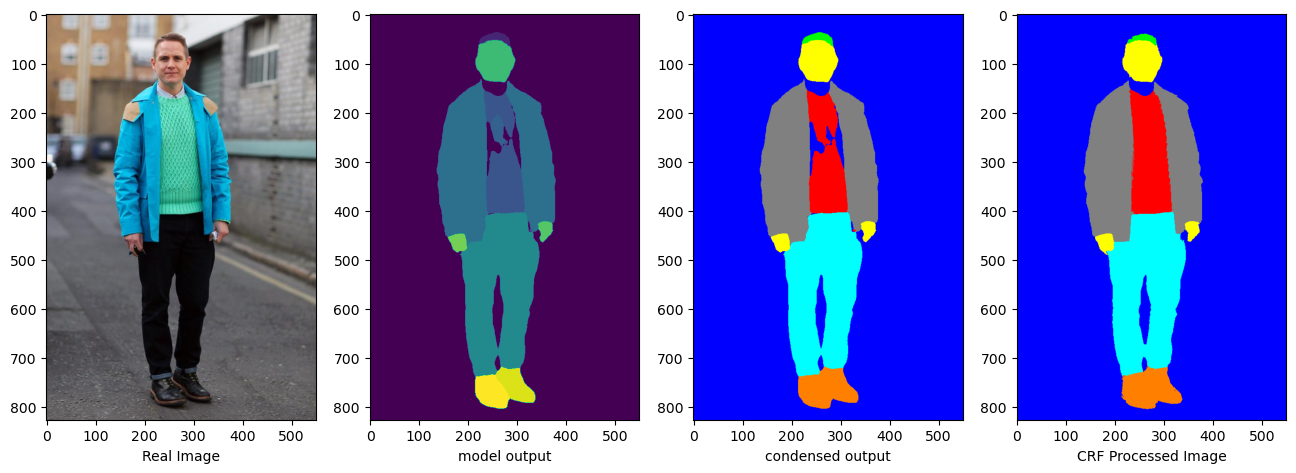

In [15]:
# Display the result
num_disp_imgs = 4
fig, ax = plt.subplots(1, num_disp_imgs, figsize=(16, 16))
ax[0].imshow(real_image)
ax[0].set_xlabel('Real Image')
ax[1].imshow(parsing_result)
ax[1].set_xlabel('model output')
ax[2].imshow(rgb_mask_img)
ax[2].set_xlabel('condensed output')
ax[3].imshow(crf_image)
ax[3].set_xlabel('CRF Processed Image')

In [16]:
# sanity check code to ensure the rgb mask is correct
pix_arr = np.array(crf_image)
a = np.unique(pix_arr.reshape(-1, pix_arr.shape[2]), axis=0)
print(a)
print(a.shape)

[[  0   0 255]
 [  0 255   0]
 [  0 255 255]
 [128 128 128]
 [255   0   0]
 [255 128   0]
 [255 255   0]]
(7, 3)


## Colour inference

In [17]:
# function to get the mask for a particular class
def get_mask(class_name, pixels):
    R, G, B = int(seg_df[seg_df['class_name']==class_name]['r']), int(seg_df[seg_df['class_name']==class_name]['g']), int(seg_df[seg_df['class_name']==class_name]['b'])
    mask_array = np.array(pixels)
    mask = np.all(mask_array == [R, G, B], axis=-1)
    
    return mask

In [18]:
# implementation of K-means clustering to get the dominant colors
Point = namedtuple('Point', ('coords', 'n', 'ct'))
Cluster = namedtuple('Cluster', ('points', 'center', 'n'))

def get_points(img, mask):
    points = []
    w, h = img.size
    num_channels = len(img.getbands())
    for y in range(h):
        for x in range(w):
            if mask[y][x]:
                color = img.getpixel((x, y))
                points.append(Point(color, num_channels, 1))
    return points

rtoh = lambda rgb: '#%s' % ''.join(('%02x' % p for p in rgb))

def colorz(img, n=1, mask=None, monotone=True):
    img = Image.fromarray(img)

    points = get_points(img, mask)
    if monotone:
        clusters = kmeans(points, n, 1)      
    else:
        k = find_optimal_clusters(points, max_k=3)
        clusters = kmeans(points, k, 1)
    rgbs = [map(int, c.center.coords) for c in clusters]
    return map(rtoh, rgbs), clusters

def euclidean(p1, p2):
    return sqrt(sum([
        ((p1.coords[i] - p2.coords[i]) ** 2) for i in range(p1.n)
    ]))

def calculate_center(points, n):
    vals = [0.0 for i in range(n)]
    plen = 0
    for p in points:
        plen += p.ct
        for i in range(n):
            vals[i] += (p.coords[i] * p.ct)
    if plen == 0:
        return points[0]
    return Point([(v / plen) for v in vals], n, 1)

def kmeans(points, k, min_diff):
    clusters = [Cluster([p], p, p.n) for p in random.sample(points, k)]

    while 1:
        plists = [[] for i in range(k)]

        for p in points:
            smallest_distance = float('Inf')
            for i in range(k):
                distance = euclidean(p, clusters[i].center)
                if distance < smallest_distance:
                    smallest_distance = distance
                    idx = i
            plists[idx].append(p)

        diff = 0
        for i in range(k):
            old = clusters[i]
            center = calculate_center(plists[i], old.n)
            new = Cluster(plists[i], center, old.n)
            clusters[i] = new
            diff = max(diff, euclidean(old.center, new.center))

        if diff < min_diff:
            break

    return clusters

def find_optimal_clusters(points, max_k):
    wcss = []
    for k in range(1, max_k+1):
        clusters = kmeans(points, k, 1)
        wcss.append(sum(euclidean(p, clusters[i].center) ** 2 for i in range(k) for p in clusters[i].points))
    
    # Uncomment the below lines to plot the elbow curve
    # Plot the WCSS vs. k curve
    #plt.plot(range(1, max_k+1), wcss)
    #plt.title('Elbow Method')
    #plt.xlabel('Number of Clusters')
    #plt.ylabel('WCSS')
    #plt.show()
    
    # Find the elbow point
    diff = np.diff(wcss)
    diff2 = np.diff(diff)
    elbow = np.argmin(diff2) + 2
    return elbow

In [19]:
# iterator to get colors from Kmeans output
def print_iterator(it):
    iterator = []
    for x in it:
        iterator.append(x)
    return iterator

In [20]:
attrs_list = ['hair', 'skin', 'upper_body', 'coat', 'lower_body', 'footwear'] # list of attributes considered
hair_dict = {}
skin_dict = {}
upper_body_dict = {} 
coat_dict = {}
lower_body_dict = {}
footwear_dict = {}
attr_dict_list = [hair_dict, skin_dict, upper_body_dict, coat_dict, lower_body_dict, footwear_dict]
drop_indices = []

In [21]:
for i in range (0, len(attrs_list)):
    bool_val = False
    if attrs_list[i] == 'hair' or attrs_list[i] == 'skin':
        bool_val = True
    try:
        colorVal, clusts = colorz(real_image, mask = get_mask(attrs_list[i], crf_image), monotone=bool_val)
    except ValueError:
        print('ValueError: ' + attrs_list[i]+ ' at indice ' + str(i))
        drop_indices.append(i)
        continue
    colors = print_iterator(colorVal)
    clusts_points_sum = 0
    for j in range (0, len(clusts)):
        clusts_points_sum += len(clusts[j].points)
    for j in range (0, len(clusts)):
        percentage = round((len(clusts[j].points)/clusts_points_sum), 2)
        if percentage>0.1:
            attr_dict_list[i][colors[j]] = percentage

In [22]:
# drop the attributes not present in the image
for index in sorted(drop_indices, reverse=True):
    del attrs_list[index]
    del attr_dict_list[index]

In [23]:
# Open the .pk file in binary mode
with open('lab-matrix.pk', 'rb') as f:
    # Load the Python object from the file
    file_lab_matrix = pickle.load(f, encoding='latin1')

# Now you can use the Python object in your code
with open('lab-colors.pk', 'rb') as f:
    # Load the Python object from the file
    file_lab_colors = pickle.load(f, encoding='latin1')

In [24]:
print(file_lab_matrix.shape)
print(len(file_lab_colors))

(197525, 3)
197525


In [25]:
def get_lab_color(hex, file_lab_matrix, file_lab_colors): 
    rgb = sRGBColor.new_from_rgb_hex(hex) # convert hex to rgb
    lab = convert_color(rgb, LabColor) # convert rgb to lab
    color = LabColor(lab.lab_l, lab.lab_a, lab.lab_b)
    lab_color_vector = np.array([color.lab_l, color.lab_a, color.lab_b])
    delta = delta_e_cie2000(lab_color_vector, file_lab_matrix)
    closest_colour = file_lab_colors[np.argmin(delta)] # get the closest color based on distance from the lab color matrix
    return closest_colour

def HEXtoRGB(hex_code):
    h = hex_code
    h = h.lstrip('#')
    rgb_tuple =  tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    return rgb_tuple

In [26]:
# get the closest color name from the webcolors library (another implementation)
def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

## Results

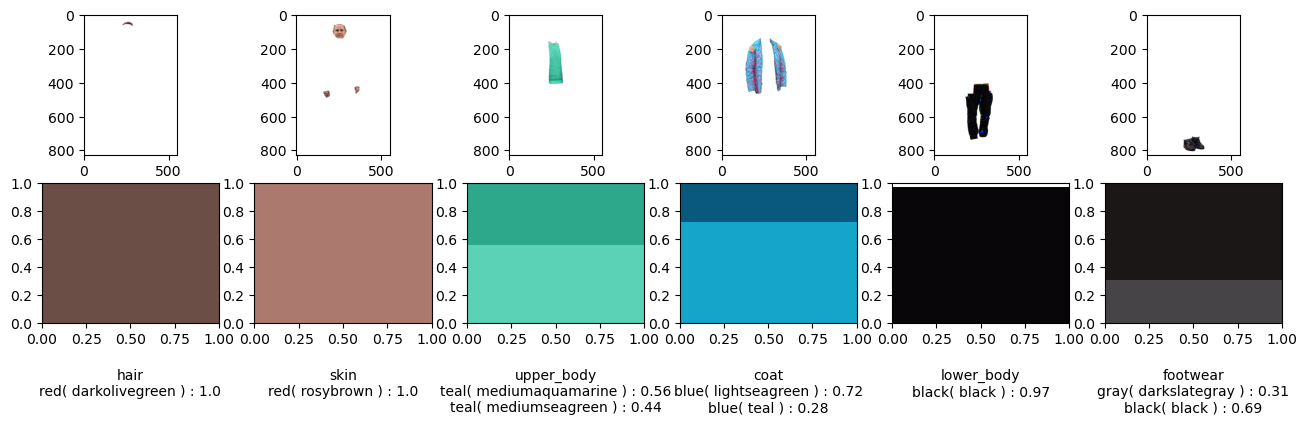

In [27]:
# display each attribute along with the color individually
num_plots = len(attr_dict_list)
fig, ax = plt.subplots(2, num_plots, figsize=(16, 4))

for i in range(len(attr_dict_list)):
    rect1 = attr_dict_list[i]
    keys = list(rect1.keys())
    strt = 1
    rect_sum = 0
    for j in range(len(keys)):
        rect = Rectangle((0, 1-strt), 1, rect1[keys[j]], facecolor=keys[j])
        rect_sum += rect1[keys[j]]
        strt = 1 - rect_sum
        ax[1][i].add_patch(rect)
    disp_str = '\n' + attrs_list[i]
    for j in range(len(keys)):
        requested_colour = HEXtoRGB(keys[j])
        actual_name, closest_name = get_colour_name(requested_colour)
        new_line = '\n' + get_lab_color(keys[j], file_lab_matrix, file_lab_colors ) + '( ' + closest_name+ ' )' + ' : ' + str(rect1[keys[j]])
        disp_str = disp_str + new_line
    ax[1][i].set_xlabel(disp_str)

    g_mask = get_mask(attrs_list[i], crf_image)
    binary_mask = g_mask.astype(np.uint8)
    bg = np.ones_like(np.array(real_image), dtype=np.uint8) * 255
    temp_masked_img = cv2.bitwise_and(bg, np.array(real_image), mask=binary_mask)
    temp_masked_img[temp_masked_img == 0] = 255
    ax[0][i].imshow(temp_masked_img)

plt.show()

Text(0.5, 0, 'Parsing result')

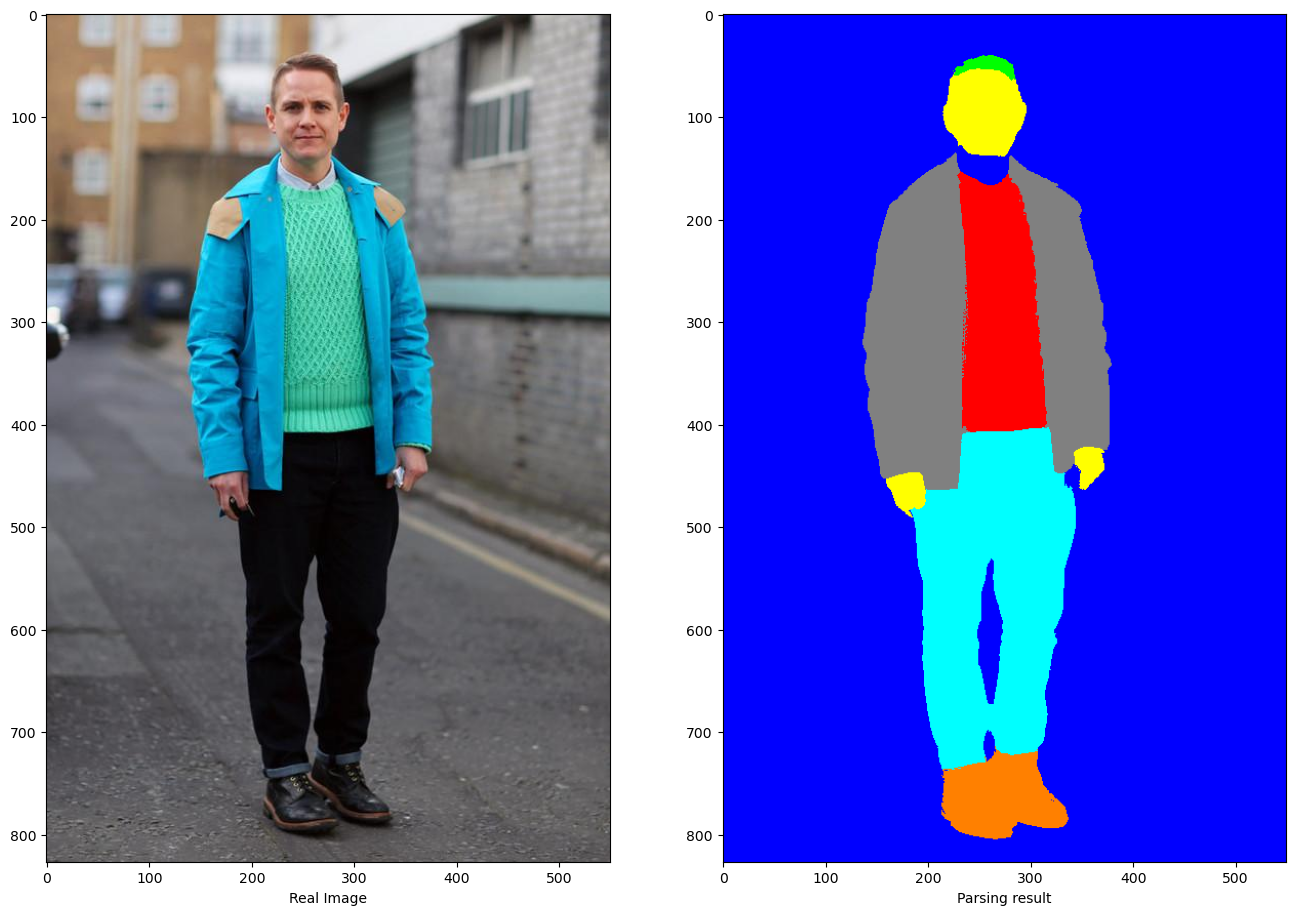

In [28]:
num_disp_imgs = 2
fig, ax = plt.subplots(1, num_disp_imgs, figsize=(16, 16))
ax[0].imshow(real_image)
ax[0].set_xlabel('Real Image')
ax[1].imshow(crf_image)
ax[1].set_xlabel('Parsing result')